### Frame by frame analysis for robust lane marking

This notebook presents the analysis performed on individual image to compute lane lines for Advanced Lane Finding project for Udacity's self-driving car nanodegree. This notebook specifically deals with identifying the lane mask, and then computing the lane location and polynomial mask for the road. 

The algorithm is presented in 2 parts as described below. 



### The algorithm

The algorithm is divided into two steps, in the first step we apply a perspective transform and compute a lane mask to identify potential locations of lane in an image, and in the next step we combine the lane mask information with previous frame information to compute the final lane. The second step is performed to discard effects of noisy or 

#### Part 1: Get lane mask

Figure below presents the steps involved in obtaining lane masks from the original image. The steps are divided as follows,

1. Read and undistort image: In this step, a new image is read by the program and the image is undistorted using precomputed camera distortion matrices. 
2. Perspective transform: Read in new image and apply perspective transform. Perspective transformation gives us bird's eye view of the road, this makes further processing easier as any irrelevant information about background is removed from the warped image. 
3. Color Masks: Once we obtain the perspective transform, we next apply color masks to identify yellow and white pixels in the image. Color masks are applied after converting the image from RGB to HSV space. HSV space is more suited for identifying colors as it segements the colors into the color them selves (Hue), the ammount of color (Saturation) and brightness (Value). We identify yellow color as the pixels whose HSV-transformed intensities are between \\([ 0, 100, 100]\\) and \\([ 50, 255, 255]\\), and white color as the pixels with intensities between \\( [20,   0,   180]\\) and \\([255,  80, 255] \\).
4. Sobel Filters: In addition to the color masks, we apply sobel filters to detect edges. We apply sobel filters on L and S channels of image, as these were found to be robust to color and lighting variations. After multiple trial and error, we decided to use the magnitude of gradient along x- and y- directions with thresholds of 50 to 200 as good candidates to identify the edges. 
5. Combine sobel and color masks: In a final step we combined candidate lane pixels from Sobel filters  and color masks to obtain potential lane regions. 

These  steps are illustrated in the figure below. 

<img src='images/lane_mask.png'>


#### Part 2: Compute lanes 

We implement different lane calculations for the first frame and subsequent frames. In the first frame, we compute the lanes using computer vision methods, however, in the later frames, we skip these steps. Instead, we place windows of 50 pixel width centered on the lanes computed in the previous frame, and search within these windows. This significanly reduced the computation time, for our algorithm. We were able to achieve 10 Frames/s lane estimation rate. 


#### Compute lanes for the first frame

The next step is to compute lanes for the first image. To do so, we take the lane mask from the previous step, and take only the bottom half of the image. We next use scipy to compute the locations of the peaks corresponding to the left and right lanes. 


<img src='images/hist_lane1.png'>

We then place a window of size 50 pixels centered at these peaks, and search for peaks in the bottom 8th of the image. Next we move up to the next 1/8th of the image and center windows at the peaks detected in the bottom 1/8th of the image. We repeat this process 8 times to cover the entire image. This is illustrated in the figure below. 


<img src='images/road_slices.png'>


In addition to tracking the location of the previous window, we also keep track of the displacement of previous window. In cases where no peaks are found, we place a window centered at the location calculated assuming the location of previous window moved by a precomputed offset. The windows and lanes obtained after this step are shown below.  

<img src='images/sliding_window.png'>




We next fit a quadratic function with independent variable 'x' and dependent variable 'y' to the points within the line mask using numpy's polyfit function. 

<img src='images/poly_fit.png'>

After computing the lanes, we draw them back on the original undistorted image as follows. 

<img src='images/lane_draw.png'>

In [1]:
# First we import packages
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

### Load image

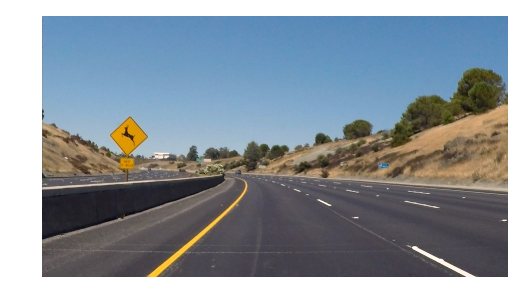

In [2]:
# Next we read in image 
image = mpimg.imread('test_images/test2.jpg')
#image = cv2.resize(image,(960,540))
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

### Helper functions

Below we define some helper functions. 

In [3]:
kernel_size = 5

def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        

def undistort_image(img, mtx, dist):
    # Undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


### 1. Undistort image. 

First we load the original image and undistort it. Panels below present the original image, and undistorted image. As can be seen, the undistorted image is different from the original image. 

In [4]:
image_ud = undistort_image(image, mtx_camera , dist_camera )

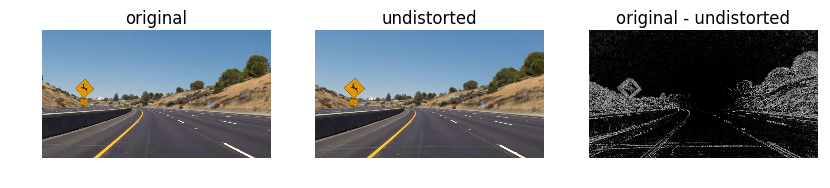

In [5]:
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

### Apply perspective transform

We first apply perspective transform to get bird eye-view. 

In [6]:
image = image_ud

In [7]:
img_size = np.shape(image)

In [8]:
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - .9*np.uint(img_size[1]/2)
cbr_window = c_window + .9*np.uint(img_size[1]/2)


In [9]:
src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

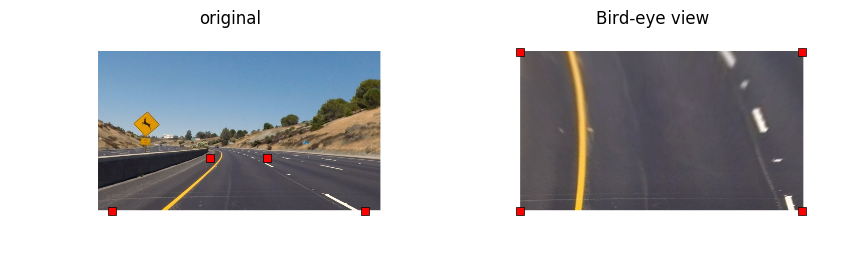

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

### Apply color mask

Next we will apply color masks to identify yellow and white lane markings in the bird-eye view image.

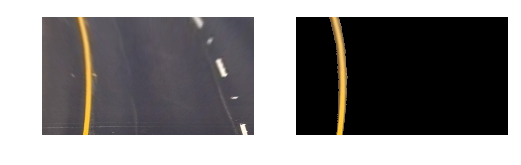

In [11]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])


res_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

res = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res)
plt.axis('off');

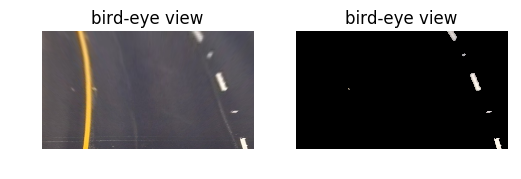

In [12]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)


white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

#white_hsv_low  = np.array([  0,   0,    80])
#white_hsv_high = np.array([ 255,  255, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');


### Combine color masks

We next combine the color masks for while and yellow lanes. 

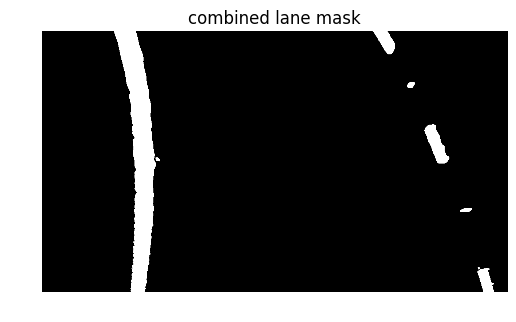

In [13]:
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

### Apply Sobel filters

Next we will apply sobel filters to the L and S channels of the image. We chose L and S channels because in L and S channels, the lanes were more prominent. We chose this color scheme after a lot of tiral and error. 

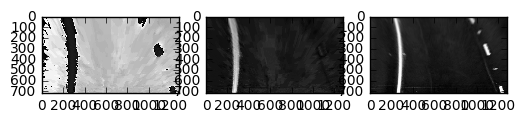

In [14]:
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

### Apply sobel filters to L and S channels 

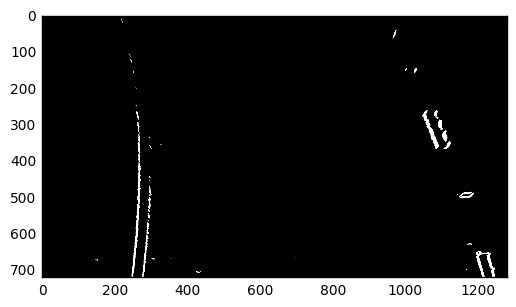

In [15]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

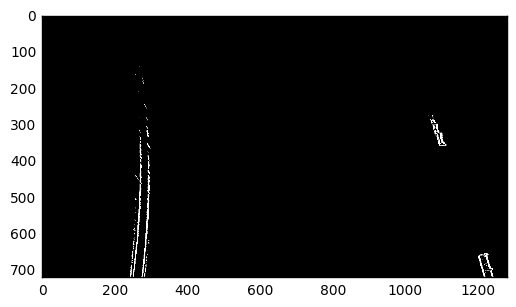

In [16]:
img_gs = image_HLS[:,:,2]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

In [17]:
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

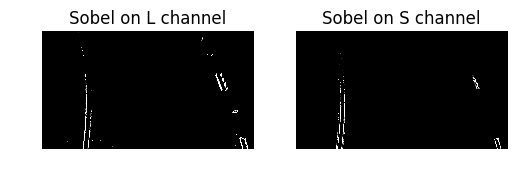

In [18]:

plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');

### Combine Sobel filters from L and S channels. 


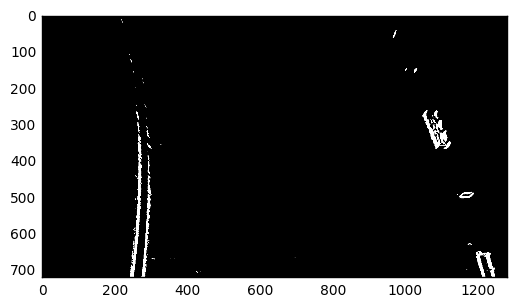

In [19]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb = gaussian_blur(image_cmb,3)
plt.imshow(image_cmb,cmap='gray')

### Combine color masks and sobel filters

We next combine color masks and sobel filters to get a representation of where lanes could be. 

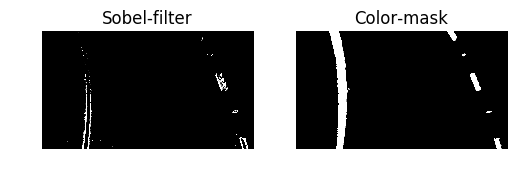

In [20]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
#image_cmb = cv2.bitwise_or(image_cmb,res)
#image_cmb = gaussian_blur(image_cmb,3)

image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')


(-0.5, 1279.5, 719.5, -0.5)

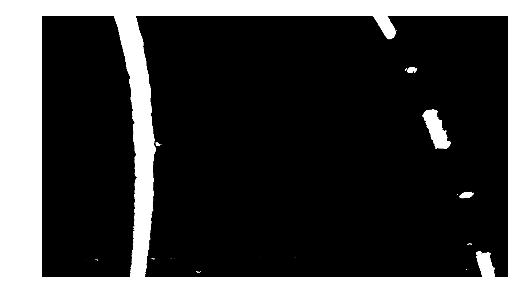

In [21]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.axis('off')

From above, we get good representation of lane masks. However, these masks are based on yellow and white colors and sobel filter calculations. If there are additional drawings or markings on the road, this algorithm will not give two neat lines as above, we will therefore perform additional analysis to isolate the lane loactions. 



### Isolate lanes

We will next perform additional analysis to isolate lanes from above. We will take bottom half of the image and compute histogram of distribution of pixel intensities. 

(0, 1280)

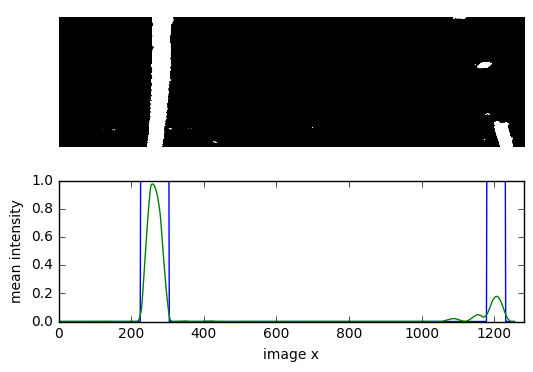

In [22]:
#image_cmb1 = gaussian_blur(image_cmb1,5) 
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)


plt.subplot(2,1,1)
plt.imshow(image_cmb1[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])



Once we get the two peaks as identified above,w we will place a window of width 50 centered at the peak location in the bottom 1/8th of the image and slide it up and incrementally compute window locations based on location of peaks. This is illustrated in the code below. 

265 1194


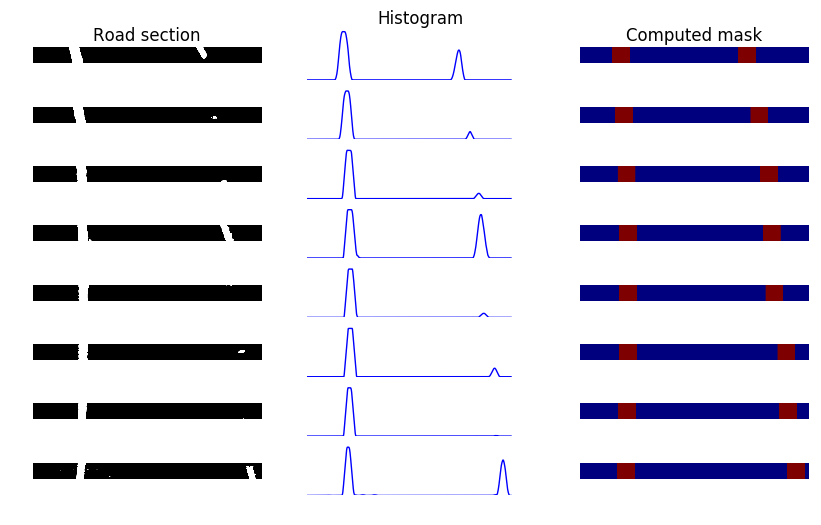

In [23]:
# Get peaks
indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])
window_size=50
val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
ind_sorted = np.argsort(-val_ind)

ind_peakR = indexes[ind_sorted[0]]
ind_peakL = indexes[ind_sorted[1]]
if ind_peakR<ind_peakL:
    ind_temp = ind_peakR
    ind_peakR = ind_peakL
    ind_peakL = ind_temp

n_vals = 8

# Get windows for bottom frame
ind_min_L = ind_peakL-50
ind_max_L = ind_peakL+50

ind_min_R = ind_peakR-50
ind_max_R = ind_peakR+50

mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)
print(ind_peakL,ind_peakR)
ind_peakR_prev = ind_peakR
ind_peakL_prev = ind_peakL

plt.figure(figsize=(10,6))
# Slide window up for each 1/8th of image
for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
    mean_lane_y = np.mean(image_cmb1[img_y2:img_y1,:],axis=0)
    mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
    indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
    
    
    # If 2 peaks are detected assign peaks to correct side.
        
    if len(indexes)>1.5:
        val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
        ind_sorted = np.argsort(-val_ind)

        ind_peakR = indexes[ind_sorted[0]]
        ind_peakL = indexes[ind_sorted[1]]
        if ind_peakR<ind_peakL:
            ind_temp = ind_peakR
            ind_peakR = ind_peakL
            ind_peakL = ind_temp
            
    else:
        # If 1 peak is detected, assign peak to closest peak in previous 1/8th image.
        if len(indexes)==1:
            if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                ind_peakR = indexes[0]
                ind_peakL = ind_peakL_prev
            else:
                ind_peakL = indexes[0]
                ind_peakR = ind_peakR_prev
        else:
            ind_peakL = ind_peakL_prev
            ind_peakR = ind_peakR_prev
            
                
    if np.abs(ind_peakL-ind_peakL_prev)>=100:
        ind_peakL = ind_peakL_prev
    if np.abs(ind_peakR-ind_peakR_prev)>=100:
        ind_peakR = ind_peakR_prev
    
            
    mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
    mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1. 
   
    ind_peakL_prev = ind_peakL
    ind_peakR_prev = ind_peakR
    
    
    

    plt.subplot(8,3,25-3*i-2)
    #plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.plot(mean_lane_y)
    if i==7:
        plt.title('Histogram')
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')  
    plt.subplot(8,3,25-3*i-3)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    #plt.plot(mean_lane_y)
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    if i==7:
        plt.title('Road section')
    plt.axis('off') 
    plt.subplot(8,3,25-3*i-1)
    plt.imshow(mask_L_poly[img_y2:img_y1,:]+mask_R_poly[img_y2:img_y1,:])
    plt.axis('off')
    if i==7:
        plt.title('Computed mask')
    
    
    


Below we verify if the same masks are obtained from a functional implementation also. 

In [24]:
def get_initial_mask(img,window_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/20.
    mean_ln = np.mean(img[img_size[0]/2:,:],axis=0)
    mean_ln = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
        mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

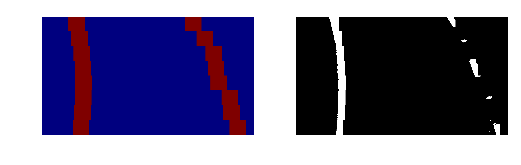

In [25]:
mask_L_poly,mask_R_poly = get_initial_mask(image_cmb1,50)

plt.subplot(1,2,1)
plt.imshow(mask_R_poly+mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(image_cmb1,image_cmb1,mask=mask_R_poly+mask_L_poly),cmap='gray')

#### Next  we will isolate pixels for left and right lanes.

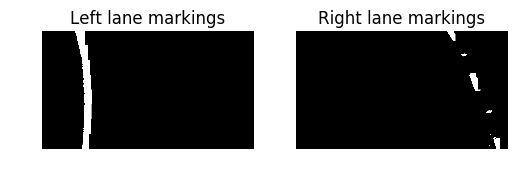

In [26]:
mask_L = mask_L_poly

img_L = np.copy(image_cmb1)
img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)


mask_R = mask_R_poly

img_R = np.copy(image_cmb1)
img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)
#img_L = gaussian_blur(img_L,5)
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings');    

#### Once we isolate pixels for left and right lanes, we will compute best quadratic fit to the curve. We will approximate lanes with 10 piecewise continuous lines. Rationale for implementing this was to test full lane-based outlier rejection. However, i did not use it later.

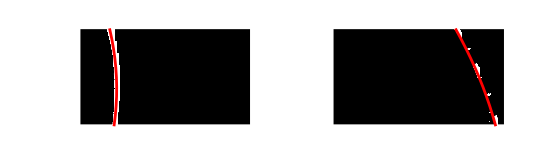

In [27]:
vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]



# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.plot( left_fitx,left_y,'red',linewidth=2)
plt.axis('off');

vals = np.argwhere(img_R>.5)

all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]



# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx,right_y,'r',linewidth=2)
plt.axis('off');

### Verify that we get the same output from function also

In [28]:
def get_mask_poly(img,poly_fit,window_sz):
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)
    

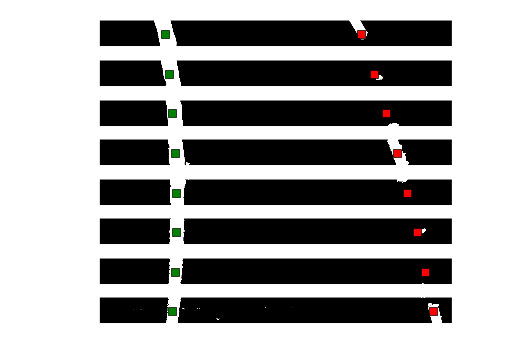

In [29]:
window_sz = 20
mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)

left_pts = []
right_pts = []

pt_y_all = []

for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    

    pt_y = (img_y1+img_y2)/2
    pt_y_all.append(pt_y)
    left_pt = np.round(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    right_pt = np.round(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    
    right_pts.append(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    left_pts.append(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    
    mask_L_poly[img_y2:img_y1,left_pt-window_sz:left_pt+window_sz] = 1.     
    mask_R_poly[img_y2:img_y1,right_pt-window_sz:right_pt+window_sz] = 1.     

    plt.subplot(8,1,8-i)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.plot(left_pt,pt_y-img_y2,'gs')
    plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')  
    
    

#### Finally, draw the lanes back on the original image.

In [30]:
warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

col_L = (255,255,0)
col_R = (255,255,255)    

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 


result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)

(-0.5, 1279.5, 719.5, -0.5)

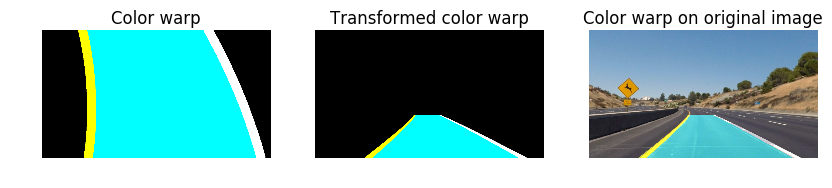

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')

### Conclusion
The work in this notebook will be combined with filtering and outlier rejection method to develop a more robust lane tracking algorithm.